In [1]:
import pandas as pd
import numpy as np
import ast
import re
import torch
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"


from transformers import pipeline,AutoTokenizer, AutoModelForSequenceClassification
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from datetime import datetime
from collections import Counter
from transformers import BertTokenizer, BertForSequenceClassification


In [2]:
# Load Data
#df = pd.read_csv('/Users/zhanghanshi/Desktop/WM_Project/my_project/cleaned_nvda.csv')
#df.head()

In [3]:
# Can be changed according to needs later, here we focus on recent 5 years data

def load_and_filter_data(filepath, start_year=2018, end_year=2022):
    """
    读取 CSV 文件并筛选指定年份范围与行数的数据。
    """
    try:
        df = pd.read_csv(filepath)

        # 只保留需要的列
        df = df[['Date', 'Cleaned_Tweet', 'Processed_Tweet', 'Emoji_Texts']]

        # 转换日期类型
        df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

        # 去除无效日期
        df = df.dropna(subset=['Date'])

        # 筛选时间范围
        df = df[(df['Date'].dt.year >= start_year) & (df['Date'].dt.year <= end_year)]

        # 限制行数
        # df = df.head(n_rows)

        return df
        
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

def validate_data(df):
    """验证数据完整性"""
    required_columns = ['Date', 'Cleaned_Tweet', 'Processed_Tweet', 'Emoji_Texts']
    if not all(col in df.columns for col in required_columns):
        print("Missing required columns")
        return False
    return True

In [4]:
def get_descriptive_stats(df):
    """
    计算描述性统计信息
    
    Args:
        df (pd.DataFrame): 输入数据框
        
    Returns:
        pd.DataFrame: 包含统计信息的DataFrame（与简单版结构一致）
    """
    # 保持与简单版相同的返回结构
    stats = {
        'total_tweets': len(df),
        'unique_tweets': df['Processed_Tweet'].nunique(),
        'avg_length': df['Processed_Tweet'].apply(lambda x: len(str(x).split())).mean(),
        'emoji_count': df['Emoji_Texts'].notna().sum(),
        'most_common_words': []
    }

    try:
        # 输入验证
        required_columns = ['Processed_Tweet', 'Emoji_Texts']
        missing_columns = [col for col in required_columns if col not in df.columns]
        if missing_columns:
            raise ValueError(f"Missing required columns: {missing_columns}")

        # 计算最常见单词（保持简单版逻辑）
        all_words = ' '.join(df['Processed_Tweet'].fillna('')).split()
        all_words = [w for w in all_words if w.isalnum()]
        word_counts = Counter(all_words)
        stats['most_common_words'] = word_counts.most_common(20)
        stats['avg_tweet_length'] = df['Processed_Tweet'].str.len().mean()
        
        # 表情符号统计（简化版）
        if 'Emoji_Texts' in df.columns:
            try:
                emoji_lists = df['Emoji_Texts'].apply(
                    lambda x: ast.literal_eval(x) if isinstance(x, str) else x if isinstance(x, list) else []
                )
                stats['emoji_count'] = emoji_lists.apply(len).sum()
            except:
                pass

    except Exception as e:
        print(f"Warning in get_descriptive_stats: {str(e)}")
        # 保持数据结构一致，即使出错
        stats['most_common_words'] = [('Error', 0)]

    return pd.DataFrame.from_dict(stats, orient='index', columns=['Value'])

In [5]:
# Emoji Distribution
def plot_top_emojis(df, emoji_column='Emoji_Texts', top_n=10, color='skyblue'):
    """
    从DataFrame中统计并绘制最常用的emoji表情
    
    参数:
        df (pd.DataFrame): 包含emoji数据的DataFrame
        emoji_column (str): 包含emoji列表的列名，默认为'Emoji_Texts'
        top_n (int): 显示前多少个emoji，默认为10
        color (str): 条形图的颜色，默认为'skyblue'
    """
    # 确保emoji列中的字符串转换为列表
    df[emoji_column] = df[emoji_column].apply(
        lambda x: ast.literal_eval(x) if isinstance(x, str) else x
    )
    
    # 统计所有emoji的出现频率
    emoji_counter = Counter(
        [emoji for sublist in df[emoji_column] for emoji in sublist]
    )
    
    # 获取出现频率最高的emoji
    top_emoji_series = pd.Series(dict(emoji_counter.most_common(top_n)))
    
    # 绘制水平条形图
    top_emoji_series.plot(
        kind='barh', 
        title=f'Top {top_n} Emojis', 
        color=color
    )
    
    plt.xlabel('Frequency')
    plt.ylabel('Emoji')
    plt.tight_layout()
    plt.show()

 

# No need to do Enhanced Sentiment Analysis Including Emojis based on the results.

In [6]:
# Split tweets into financial and non-financial

def classify_financial_text(text):
    """
    判断文本是否包含金融相关术语
    
    Args:
        text (str): 输入文本
        
    Returns:
        bool: 如果文本包含金融相关术语返回True，否则返回False
    """
    try:
        # 预定义金融术语正则表达式
        financial_pattern = r'\b(?:\$[A-Z]{1,5}\b|stock(?:\s*price|s?)|price\s*target|market\s*(?:cap|value)|' \
                          r'shares|share\s*price|earnings(?:\s*report|per\s*share|call)|semiconductor|chip\s*industry|' \
                          r'invest(?:ing|ment)|trading|portfolio|dividend|buyback|' \
                          r'\b(?:bull|bear)(?:ish|market)\b|valuation|P/E|price-to-earnings|' \
                          r'analyst\s*rating|upgrade|downgrade|(?:financial|quarterly)\s*results|' \
                          r'volume|liquidity|SEC\s*filing|10-[KQ]|IPO|FPO|secondary\s*offering)'
        
        # 将输入转换为字符串并检查是否包含金融术语
        return bool(re.search(financial_pattern, str(text), flags=re.IGNORECASE))
    except Exception as e:
        print(f"Error in classify_financial_text: {str(e)}")
        return False

In [30]:
class SentimentAnalyzer:
    def __init__(self, finbert_model, bert_model):
        self.finbert = finbert_model
        self.bert = bert_model
        self.vader = SentimentIntensityAnalyzer()

    def is_initialized(self):
        """Check if all required models are initialized"""
        return all([self.finbert is not None, self.bert is not None, self.vader is not None])

    def analyze_financial_text(self, texts, batch_size=32):
        results = []
        for i in range(0, len(texts), batch_size):
            batch = texts[i:i+batch_size]
            try:
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()
                output = self.finbert(batch, batch_size=batch_size)
                results.extend(output)
            except Exception as e:
                print(f"FinBERT Error in batch {i}: {e}")
                results.extend([{'label': 'ERROR', 'score': 0}] * len(batch))
            finally:
                gc.collect()
        return results

    def analyze_non_financial_text(self, texts, batch_size=32):
        results = []
        for i in range(0, len(texts), batch_size):
            batch = texts[i:i+batch_size]
            try:
                output = self.bert(batch,batch_size=batch_size)
                results.extend(output)
            except Exception as e:
                print(f"BERT Error in batch {i}: {e}")
                results.extend([{'label': 'ERROR', 'score': 0}] * len(batch))
        return results

    def analyze_vader(self, texts):
        results = []
        for text in texts:
            score = self.vader.polarity_scores(text)['compound']
            results.append(score)
        return results

    @staticmethod
    def vader_to_label(score):
        if score >= 0.05:
            return 'positive'
        elif score <= -0.05:
            return 'negative'
        else:
            return 'neutral'





Loading data...
Validating data...
Calculating descriptive statistics...

Basic Statistics:
Total tweets: 360643
Unique tweets: 302993
Average length (words): 8.8
Tweets with emojis: 90140

Top 20 Most Common Words:
nvda: 377944
amd: 36645
go: 32650
buy: 27353
stock: 22779
call: 22531
today: 22376
aapl: 20615
market: 20373
day: 20110
like: 19984
get: 18984
spi: 18795
look: 16583
week: 16413
short: 16280
see: 16008
tsla: 15032
sell: 14788
time: 14453

Average tweet length (chars): 47.9

Initializing sentiment analyzers...


Device set to use mps:0
Device set to use mps:0



Classifying financial and non-financial texts...
Financial tweets: 48805
Non-financial tweets: 311838

Performing sentiment analysis...
Analyzing financial texts with FinBERT...
Analyzing non-financial texts with BERT...
Analyzing non-financial texts with VADER...
Saved daily_sentiment_bert.csv
Saved daily_sentiment_vader.csv

Generating visualizations...


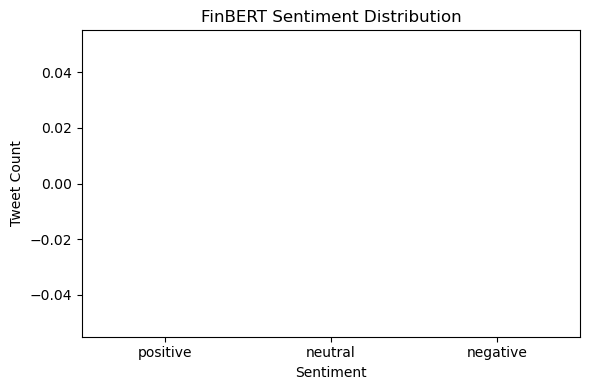

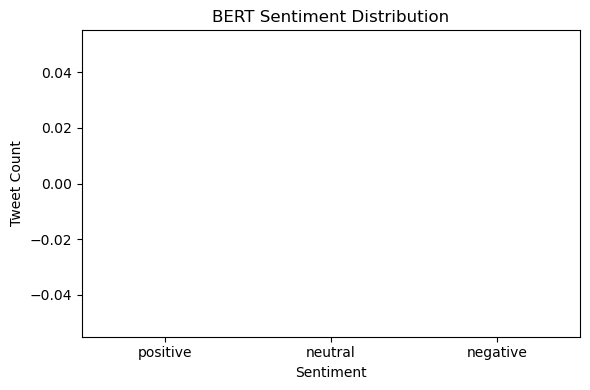

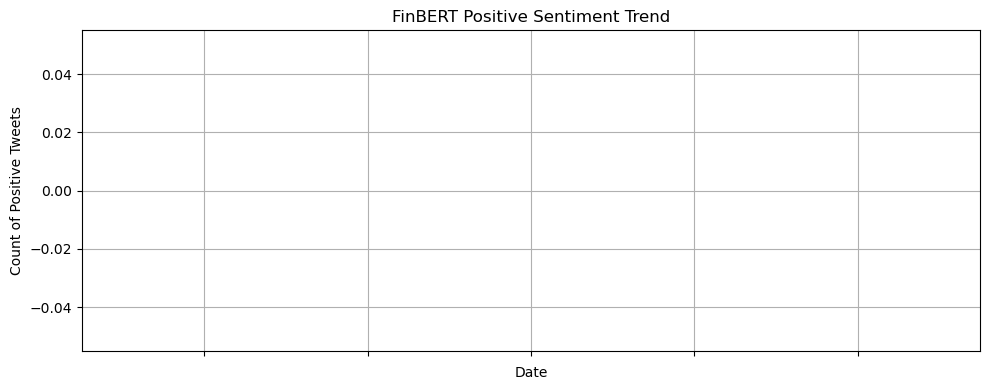

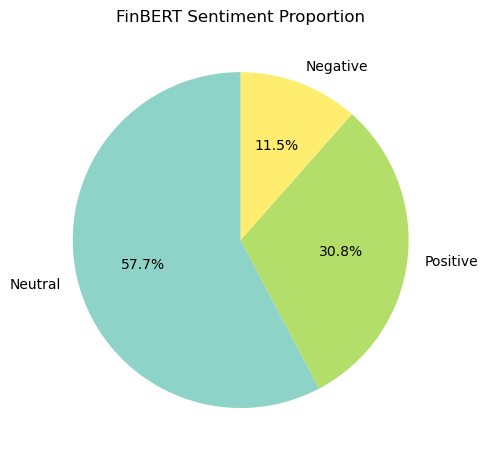

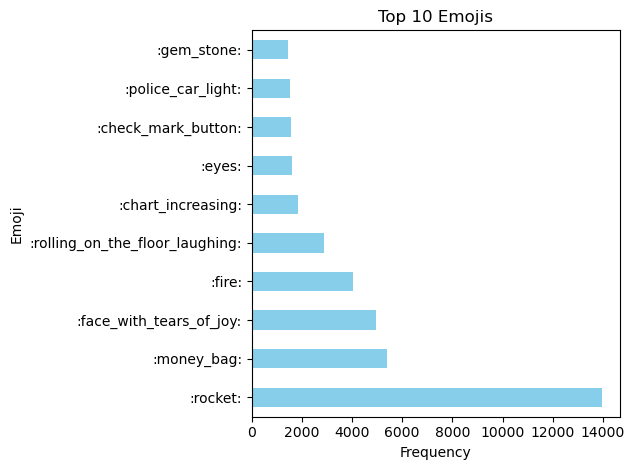


Analysis completed successfully!


In [31]:
def main():
    try:
        # 1. 加载数据
        print("Loading data...")
        df = load_and_filter_data("/Users/zhanghanshi/Desktop/WM_Project/my_project/cleaned_nvda.csv")
        if df is None or df.empty:
            print("Error: Failed to load data or data is empty")
            return
        
        # 2. 验证数据
        print("Validating data...")
        if not validate_data(df):
            print("Error: Data validation failed")
            return
        
        # 3. 获取描述性统计
        print("Calculating descriptive statistics...")
        stats_df = get_descriptive_stats(df)

        # 打印统计信息
        print("\nBasic Statistics:")
        print(f"Total tweets: {stats_df.loc['total_tweets', 'Value']}")
        print(f"Unique tweets: {stats_df.loc['unique_tweets', 'Value']}")
        print(f"Average length (words): {stats_df.loc['avg_length', 'Value']:.1f}")
        print(f"Tweets with emojis: {stats_df.loc['emoji_count', 'Value']}")

        # 打印最常见单词（带防御性检查）
        print("\nTop 20 Most Common Words:")
        common_words = stats_df.loc['most_common_words', 'Value']
        if isinstance(common_words, list) and len(common_words) > 0:
            for word, count in common_words:
                print(f"{word}: {count}")
        else:
            print("No common words data available")

        # 可选：打印其他你可能需要的统计信息
        if 'avg_tweet_length' in stats_df.index:
            print(f"\nAverage tweet length (chars): {stats_df.loc['avg_tweet_length', 'Value']:.1f}")
        
        # 4. 初始化分析器
        print("\nInitializing sentiment analyzers...")

        # FinBERT pipeline
        finbert_pipeline = pipeline("sentiment-analysis", model="yiyanghkust/finbert-tone",truncation=True,max_length=512)

        # BERT pipeline
        tokenizer = AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")
        model = AutoModelForSequenceClassification.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")
        bert_pipeline = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer,truncation=True,max_length=512 )

        # 初始化 SentimentAnalyzer 实例
        analyzer = SentimentAnalyzer(finbert_pipeline, bert_pipeline)

        if not analyzer.is_initialized():
            print("Error: Failed to initialize sentiment analyzers")
            return
        
        # 5. 分类金融和非金融文本
        print("\nClassifying financial and non-financial texts...")
        df['is_financial'] = df['Cleaned_Tweet'].apply(classify_financial_text)
        
        df_fin = df[df['is_financial']].copy()
        df_nonfin = df[~df['is_financial']].copy()
        
        print(f"Financial tweets: {len(df_fin)}")
        print(f"Non-financial tweets: {len(df_nonfin)}")
        
        # 6. 执行情感分析
        print("\nPerforming sentiment analysis...")
        
        # ---- 金融文本：使用 FinBERT ----
        print("Analyzing financial texts with FinBERT...")
        results_fin = analyzer.analyze_financial_text(df_fin['Cleaned_Tweet'].tolist())
        df_result_fin = pd.DataFrame(results_fin)
        df_fin = df_fin.reset_index(drop=True)
        df_result_fin = df_result_fin.reset_index(drop=True)
        df_fin = pd.concat([df_fin, df_result_fin], axis=1)
        df_fin['sentiment_score'] = df_fin['label'].str.lower().map({'positive': 1, 'neutral': 0, 'negative': -1})
        df_fin['category'] = 'financial'

        # ---- 非金融文本：使用 BERT ----
        print("Analyzing non-financial texts with BERT...")
        results_nonfin_bert = analyzer.analyze_non_financial_text(df_nonfin['Cleaned_Tweet'].tolist())
        df_result_nonfin_bert = pd.DataFrame(results_nonfin_bert)
        df_nonfin_bert = df_nonfin.reset_index(drop=True)
        df_result_nonfin_bert = df_result_nonfin_bert.reset_index(drop=True)
        df_nonfin_bert = pd.concat([df_nonfin_bert, df_result_nonfin_bert], axis=1)
        df_nonfin_bert['sentiment_score'] = df_nonfin_bert['label'].map({'positive': 1, 'neutral': 0, 'negative': -1})
        df_nonfin_bert['category'] = 'non_financial'

        # ---- 非金融文本：使用 VADER ----
        print("Analyzing non-financial texts with VADER...")
        vader_scores = analyzer.analyze_vader(df_nonfin['Cleaned_Tweet'].tolist())
        df_nonfin_vader = df_nonfin.copy()
        df_nonfin_vader['sentiment_score'] = vader_scores
        df_nonfin_vader['category'] = 'non_financial'

        # ---- 合并 FinBERT + BERT 非金融结果 ----
        df_bert_combined = pd.concat([df_fin, df_nonfin_bert], ignore_index=True)
        df_bert_combined['Date'] = pd.to_datetime(df_bert_combined['Date'])
        df_daily_bert_sentiment = df_bert_combined.groupby(df_bert_combined['Date'].dt.date)['sentiment_score'].mean().reset_index()
        df_daily_bert_sentiment.columns = ['date', 'avg_sentiment_score']
        df_daily_bert_sentiment.to_csv("daily_sentiment_bert.csv", index=False)
        print("Saved daily_sentiment_bert.csv")

        # ---- 合并 FinBERT + VADER 非金融结果 ----
        df_vader_combined = pd.concat([df_fin, df_nonfin_vader], ignore_index=True)
        df_vader_combined['Date'] = pd.to_datetime(df_vader_combined['Date'])
        df_daily_vader_sentiment = df_vader_combined.groupby(df_vader_combined['Date'].dt.date)['sentiment_score'].mean().reset_index()
        df_daily_vader_sentiment.columns = ['date', 'avg_sentiment_score']
        df_daily_vader_sentiment.to_csv("daily_sentiment_vader.csv", index=False)
        print("Saved daily_sentiment_vader.csv")
        
        
        print("\nAnalysis completed successfully!")
        
    except Exception as e:
        print(f"Error in main execution: {str(e)}")
        import traceback
        print(traceback.format_exc())

if __name__ == "__main__":
    main()